In [197]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM


### Anomaly Detection

In [ ]:
data = pd.read_csv('opros_molodeshi.csv')
data

Обработка данных

In [ ]:
data.drop_duplicates()

In [140]:
mas=[i for i in data.columns if data[i].dtypes=='float64' or data[i].dtypes=='int64']

In [141]:
for i in mas:
    if data[i].isnull().sum() > 0:
        data[i] = data[i].fillna(0)


In [142]:
data[i].isna().any()


False

Isolation Forest

Визуализация выбросов

In [166]:
import plotly.express as px

# plotting scattered graph
fig = px.scatter([i for i in range(len(data['Height']))], y=data['Height'])
fig.show()


Возьмём переменную "Рост" для обнаружений аномалий. На визуализации видим, что есть некоторые выбросы. 

In [ ]:
x1 = data[['Height']]
x1

In [262]:
a = x1[x1['Height'] > 140] #Устанавливаем условие для нормального роста
b = x1[x1['Height'] < 100] #Устанавливаем условие для аномального роста

print("Аномальный рост :", len(b))
print("Нормальный рост :", len(a))


Аномальный рост : 21
Нормальный рост : 989


Видим что у на 21 аномалия

Определение и подгонка модели

In [169]:
# Параметр contamation(загрязнение) определяет приблизительную оценку процента выброса наших данных. Из 1010 строк у нас 21 аномалия. Это примерно 2%.
model = IsolationForest(n_estimators=100, max_samples='auto',
                        contamination=float(0.02), max_features=1.0)
model.fit(x1[['Height']])# обучаем модель

c:\Python\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



IsolationForest(contamination=0.02)

In [170]:
x1['scores'] = model.decision_function(x1[['Height']])  # Вызываем decision_function() функцию обученной модели и передаём значения в столбец "scores"
x1['anomaly'] = model.predict(x1[['Height']])           # Вызываем predict() функцию обученной модели и передаём значения в столбец "anomaly"
x1


C:\Users\Admin\AppData\Local\Temp\ipykernel_3344\2759835518.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Admin\AppData\Local\Temp\ipykernel_3344\2759835518.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Height,scores,anomaly
0,163.0,0.309020,1
1,163.0,0.309020,1
2,176.0,0.318582,1
3,172.0,0.326419,1
4,170.0,0.353941,1
...,...,...,...
1005,164.0,0.292477,1
1006,183.0,0.302384,1
1007,173.0,0.324530,1
1008,173.0,0.324530,1


Отрицательное значение оценки и -1 для значений столбцов аномалий указывают на наличие аномалии. Значение 1 для аномалии представляет нормальные данные.

In [172]:
anomaly = x1.loc[x1['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print(anomaly)


     Height    scores  anomaly
51      0.0 -0.008610       -1
137     0.0 -0.008610       -1
142     0.0 -0.008610       -1
209     0.0 -0.008610       -1
276     0.0 -0.008610       -1
462     0.0 -0.008610       -1
495     0.0 -0.008610       -1
499     0.0 -0.008610       -1
551     0.0 -0.008610       -1
552     0.0 -0.008610       -1
558     0.0 -0.008610       -1
560     0.0 -0.008610       -1
657     0.0 -0.008610       -1
659     0.0 -0.008610       -1
676    62.0 -0.004675       -1
790     0.0 -0.008610       -1
885     0.0 -0.008610       -1
902     0.0 -0.008610       -1
939     0.0 -0.008610       -1
960     0.0 -0.008610       -1
964     0.0 -0.008610       -1


Наши данные представляют опрос молодёжи. Видим, что кто-то заполнил свой рост, как 62 см. Остальные не потрудились заполнить свой рост и в наших данных образовались пропуски,которые мы обработали в нули до этого.

Оценка модели

In [173]:
outliers_counter = len(x1[x1['Height'] < 100])
outliers_counter


21

In [175]:
print("Процент точности", 100 *
      list(x1['anomaly']).count(-1)/(outliers_counter))  # рассчитываем точность модели, найдя, сколько выбросов обнаружила модель, деленную на количество выбросов, присутствующих в данных.


Процент точности 100.0


SVM(Support Vector Machine)

In [252]:
df = data[["Age","Weight"]]
df.describe()

,Age,Weight
count,1010.000000,1010.000000
mean,20.292079,65.090099
std,3.289898,16.535177
min,0.000000,0.000000
25%,19.000000,55.000000
50%,20.000000,64.000000
75%,22.000000,75.000000
max,30.000000,165.000000


In [259]:
model = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.05).fit(df)# параметр nu показывает, какой процент даных аномален.
y_pred = model.predict(df)


In [263]:
anomaly_values = df.iloc[np.where(y_pred == -1)]
anomaly_values

,Age,Weight
37,21.0,101.0
49,20.0,41.0
72,28.0,52.0
131,18.0,103.0
137,0.0,0.0
142,0.0,0.0
151,20.0,100.0
158,15.0,48.0
164,20.0,0.0
209,21.0,0.0


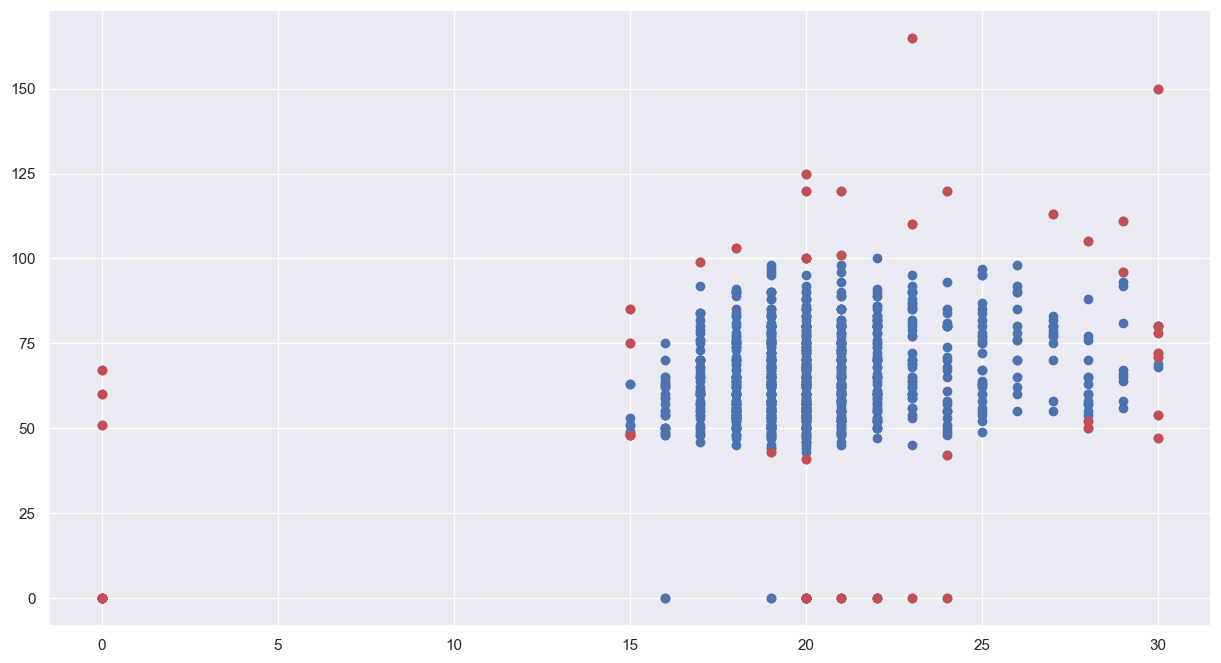

In [261]:
plt.scatter(df["Age"],df["Weight"])
plt.scatter(anomaly_values["Age"],anomaly_values["Weight"],c="r")